# PBT-XL Classification

## Links
DATASET: https://physionet.org/content/ptb-xl/1.0.1/

Project Requirements: https://apmonitor.com/pds/index.php/Main/CourseProject

Github Repository: https://github.com/scraven4/EKG-Classification


In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast

def load_raw_data(df, sampling_rate, path):
    #choose 100 for the 100hz file (500mb) and 500hz (2.7gB)
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = r"C:\Users\Hayden Wilde\PYTHON\ML Project\PTB-XL Extracted\\"
sampling_rate = 100

# load and convert annotation data
Y = pd.read_csv(r"C:\Users\Hayden Wilde\PYTHON\ML Project\PTB-XL Extracted\ptbxl_database.csv", index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [7]:
mdata = pd.DataFrame(Y)
mdata.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]


In [8]:
del mdata['patient_id'] #using ecg_id for indexing
del mdata['recording_date']
del mdata['nurse']
del mdata['site']
del mdata['device']
del mdata['heart_axis'] #I don't think the doctor has this information easily from an ekg (refers to signal direction direction)
del mdata['infarction_stadium1'] #from what I can tell this is the likelihood of an infarction which should be unknown
del mdata['infarction_stadium2']
del mdata['validated_by']
del mdata['second_opinion']
del mdata['initial_autogenerated_report']
del mdata['validated_by_human']
del mdata['scp_codes'] #too meta
del mdata['report'] # too much german and this isn't usable by an algorithm

del mdata['filename_lr']
del mdata['filename_hr']

mdata.drop(mdata.dropna(subset=['pacemaker']).index) #deletes ~40 entries
del mdata['pacemaker'] # we are not going to deal with this
mdata.drop(mdata.dropna(subset=['electrodes_problems']).index) # we are not going to deal with this
del mdata['electrodes_problems'] #deletes ~300 entrie

#drop entries with no age (~80 entries)
mdata = mdata.dropna(axis=0, subset=['age'])

#methods of meta data usage: (1) Delete height and wiehgt columns, (2) delete all rows with missing height or weight
#(1)
del mdata['height']
del mdata['weight']

# turn extra beats, static noise, baseline drift, burst noise to a true false column, (1 = True)
mdata['extra_beats'] = mdata['extra_beats'].notnull().astype(int)
mdata['burst_noise'] = mdata['burst_noise'].notnull().astype(int)
mdata['static_noise'] = mdata['static_noise'].notnull().astype(int)
mdata['baseline_drift'] = mdata['baseline_drift'].notnull().astype(int)

# we could delete entries with burst noise(~600)(extra spike)
# maybe delete baseline drift (~1600)(lower baseline), extra beats (~2000) (smooth peak)
# static noise(~3000) probably don't delete

# keeping strat_fold for validation test (strat_fold relates accuracy of diagnostic)
print(len(mdata))
mdata.head()

21748


,age,sex,baseline_drift,static_noise,burst_noise,extra_beats,strat_fold,diagnostic_superclass
ecg_id,,,,,,,,
1,56.0,1,0,1,0,0,3,[NORM]
2,19.0,0,0,0,0,0,2,[NORM]
3,37.0,1,0,0,0,0,5,[NORM]
4,24.0,0,1,0,0,0,3,[NORM]
5,19.0,1,1,0,0,0,4,[NORM]


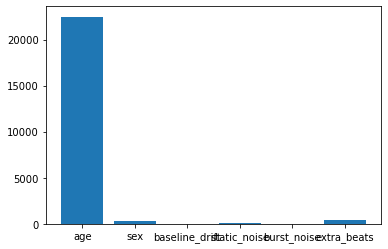

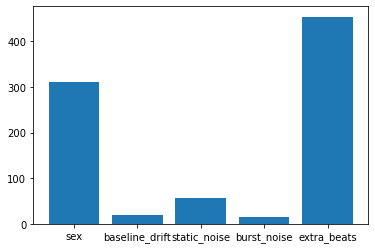

In [9]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

x_columns = mdata.columns[0:-2]
s_column = mdata.columns[-1]
x = mdata[x_columns]
s = mdata[s_column]
sn = MultiLabelBinarizer().fit_transform(s)
best = SelectKBest(score_func=chi2, k='all')
fit = best.fit(x,sn)
plt.bar(x=x.columns, height=fit.scores_)
plt.show()

x_columns = mdata.columns[1:-2]
s_column = mdata.columns[-1]
x = mdata[x_columns]
s = mdata[s_column]
sn = MultiLabelBinarizer().fit_transform(s)
best = SelectKBest(score_func=chi2, k='all')
fit = best.fit(x,sn)
plt.bar(x=x.columns, height=fit.scores_)
plt.show()


In [10]:
#It seems that baseline_drift, static_noise, and burst_noise are very uncorrelated to any condition
del mdata['baseline_drift']
del mdata['static_noise']
del mdata['burst_noise']
mdata.head()
mdata.to_csv('mdata.zip',index=False)

In [11]:
# Split data into train and test
test_fold = 10
# Train
y_train = mdata[(Y.strat_fold != test_fold)]
del y_train['strat_fold']
# Test
y_test = mdata[Y.strat_fold == test_fold]
del y_test['strat_fold']
print(y_train)

         age  sex  extra_beats diagnostic_superclass
ecg_id                                              
1       56.0    1            0                [NORM]
2       19.0    0            0                [NORM]
3       37.0    1            0                [NORM]
4       24.0    0            0                [NORM]
5       19.0    1            0                [NORM]
...      ...  ...          ...                   ...
21833   67.0    1            1                [STTC]
21834   93.0    0            0                [NORM]
21835   59.0    1            0                [STTC]
21836   64.0    1            1                [NORM]
21837   68.0    0            0                [NORM]

[19561 rows x 4 columns]


C:\Users\HAYDEN~1\AppData\Local\Temp/ipykernel_24744/2177976693.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_train = mdata[(Y.strat_fold != test_fold)]
C:\Users\HAYDEN~1\AppData\Local\Temp/ipykernel_24744/2177976693.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_test = mdata[Y.strat_fold == test_fold]
